In [2]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

C:\Users\cleme\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
crs = {'init': 'epsg:4326'}


Pour la suite des projections, on utilisera la carte des zones des zones de taxi.
Elle est disponible en format shapefile à l'adresse suivante: https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip.

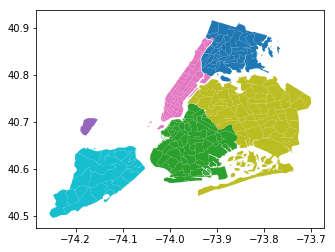

In [4]:
taxizones = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/taxi_zones.shp'
df_taxizones=gpd.read_file(taxizones).to_crs(crs)
df_taxizones.plot(column='borough', categorical=True)

# 1- Construction de la base de donnée

On va collecter des informations sur les bases de données disponibles sur le site open data de la ville de new york pour tenter de localiser des éléments particuliers (universités, cimetieres, lieux de culte, écoles...) pouvant nous donner une indication sur les caractérisqtiues socio-économiques du lieu de prise en charge, des passagers et sur le contexte de leurs courses.
Nous voulions au debut des valeurs plus économiques, cependant il nous était impossible d'extraire le PIB par habitant, le nombre de siege d'entreprise, le tax de chomage etc avec une granularité suffisamment importante pour être intéressant.
Nous avons tenté de palier à l'inaccès aux données sur les bars, cafés, restaurants etc en intégrant une analyse temporelle, détaillée dans la partie suivante.

##    a) Extraction des positions géographiques des lieux d'intérêt

Lorsque les données étaient déjà données sous forme de shapefile, les dataframe obtenus en les lisant étaient déjà des geoDtataFrame avec une variable géometrique nous donnant la position du lieu.

Les collèges et universités nous ont semblé intéressants dans notre analyse car ils attirent un grand nombre de personnes. Parmi les personnes partant d'un lieu à proximité d'un tel lieu, on peut s'attendre à voir des étudiants fortuunés (puisqu'ils se permettent de payer un taxi en plus de leur frais de scolarité), des professeurs et des conférenciers, appartenant eux aussi généralement à la classe éonomique supérieure.
On remarque que bien qu'un très grand nombre soit situé sur Manhattan, ils sont tout de même présents sur les autres quartiers.

In [5]:
## college & universities
# chargement de la donnée
college = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/original_collegeanduniversity.shp'
df_college = gpd.read_file(college).to_crs(crs)

<class 'geopandas.geodataframe.GeoDataFrame'>


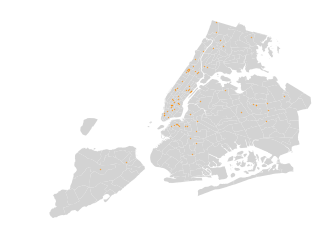

In [6]:
#représentation sur la carte
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_college.plot(ax=ax, markersize=0.1, color='darkorange')
print(type(df_college))

Nous nous sommes également intéressées aux entrées de métro. Nous avons en effet pensé que si une personne se trouve à proximité d'un grand nombre de stations de métro mais qu'elle prend le taxi, c'est que le oût économique de prendre un taxi lui semble moins important que le désagrement de prendre le métro bien qu'il soit tout proche.
Nous avons pris le nombre d'entrées et non de stations car plus il y a un grand nombre d'entrées dans une station plus celle-ci est importante et donc intéressante en terme de mobilité pour le voyageur potentiel (nombre de lignes, lignes centrales).
Ainsi, si le voyageur qui préfère le taxi au métro lorsqu'un grand nombre de bouches de métro sont à proximité, on peut s'attendre à ce qu'il ait un fort pouvoir économique et plus enclin à laisser un gros pourboire car plus indolore économiquement pour lui. 

In [7]:
##subway entrances
#chargement de la donnée
subway = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/subway_entrances.shp'
df_subway=gpd.read_file(subway).to_crs(crs)

<class 'geopandas.geodataframe.GeoDataFrame'>


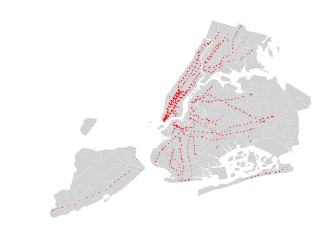

In [8]:
#représentation sur la carte
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_subway.plot(ax=ax, markersize=0.01, color='red')
print(type(df_subway))

Nous avons également intégré les hopitaux et centres médicaux dans notre analyse. Nous voulions savoir si la présence de ces batiments, qui sont principalement à l'exterieur de manhattan pouvaient être le point de départ de clients plus susceptibles de donner de gros pourboires. On peut notamment penser à la personne sortant d'hospitalisation, ne pouvant se véhiculer et nécessiatnt des précautions particulières qui sera reconnaissante envers le taxi de lui avoir permis de se déplacer sans encombre.

Le système de santé aux Etats-Unis rendant l'accès au soin inégalitaire aux Etats-unis, nous pouvons aussi considérer que la population qui est à proximité des hoptitaux est relativement aisée.

L'extraction des données géographiques de ce fichier fut plus complexe, le fichier étant disponible uniquement en .csv. Nous avons donc du extraire les données de latitude et de longitude, pour ensuite les convertir en points géometriques dans le dataframe converti en GeoDataFrame.

In [9]:
## hopitaux
#chargement de la donnée
hospital = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/original_hospitals.csv'
df_hospital = pd.read_csv(hospital, sep=";")

#Extraction de la longitude et de la latitude depuis la collonne location 1 du dataframe
df_hospital['position'] = df_hospital['Location 1'].str.replace(r'[^(]*\(|\)[^)]*', '')
df_hospital['newlongitude'] = df_hospital['position'].str.replace(r'[^,]*\,', '')
df_hospital['newlatitude']= df_hospital['position'].str.replace(r'\,[^,]*', '')

#Conversion en float puis en point géométrique avec passage au format GeoDataFrame
df_hospital['newlatitude'] = df_hospital['newlatitude'].astype(float)
df_hospital['newlongitude'] = df_hospital['newlongitude'].astype(float)
df_hospital['geometry'] = gpd.GeoSeries([Point(xy) for xy in zip(df_hospital.newlongitude, df_hospital.newlatitude)])
geodf_hospital = gpd.GeoDataFrame(df_hospital,crs=crs)
geodf_hospital = geodf_hospital.set_geometry("geometry")

<class 'geopandas.geodataframe.GeoDataFrame'>


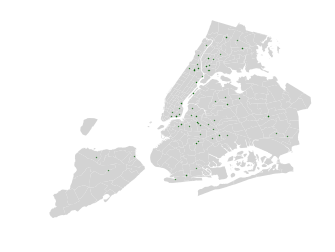

In [10]:
#Représentation sur une carte
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
geodf_hospital.plot(ax=ax, markersize=0.1, color='darkgreen')
print(type(geodf_hospital))

Nous avons ensuite utilisé un fichier recensant les poinst importants de New York. Sur ce fichier nous avons décidé d'extraire les positions géographiques des leiux de culte, des consulats, des parcs, des théatres, des écoles (primaire au lycée), des bibliothèques, des crêches et des cimetières, qui nous semblaient être des éléments géographiques importants du fait de leur signification culturelle, économique ou sociale.

Pour ce fichier, nous avons tout d'abord créé un dictionnaire reprenant les différentes abréviations utilisées dans le dtatframe. Le type de lieu n'était en effet pas défini de manière précise, on trouvait seulement le nom du lieu dans l'adresse, écrite souvent à l'aide d'abréviations.

A partir de ce dictionnaire, nous avons créé des dummies pour chaque catégorie indiquant s'il s'agissait en effet oui ou non d'un lieu de cette catégorie.

Enfin nous avons extrait les données géographiques sous forme géométrique pour chacune de ces catégories.

In [11]:
##Points of Interest
#Chargement de la donnée
PoI = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/original_PointOfInterest.shp'
df_PoI = gpd.read_file(PoI).to_crs(crs)

In [12]:
#recensement des abréviations
ab_religion = pd.Series(['religion','CATHEDRAL','SYNAGOGUE','EPISCOPAL', 'TEMPLE', 'CHUR','TMPL','TABERNACLE',' CH ', 'CATHDL', 'CHAPEL','CONGREGAT','CONGEGRATION', 'EVANGICAL LUTH','ISRAEL'])
ab_consulate = pd.Series(['consulate','CONSULATE'])
ab_park= pd.Series(['park','PARK','PLGD','PLAYGROUND', 'PLAYGRND', 'RECREATION', 'SQUARE', 'GARDEN'])
ab_theatre = pd.Series(['theatre','THEATRE', 'THTR'])
ab_school = pd.Series(['school','HS','HIGH SCHOOL', 'SCHL', ' SC ','SCHOOL','ACADEMY'])
ab_library = pd.Series(['library','LIBRARY'])
ab_daycare = pd.Series(['daycare','DAY CARE','DAYCARE','NURSERY','NURSING','NURSIG'])
ab_cemetery = pd.Series (['cemetry','CEMETERY','CMTRY'])


In [13]:
#on supprime les lignes comportant des nan dans la colonne name car impossible de les catégoriser
df_PoI=df_PoI.dropna(subset=['name'])
df_PoI.reset_index(drop=True, inplace=True)

In [14]:
# Initialisation des dummy variables
j=0
df_PoI['dum_religion']=0
df_PoI['dum_consulate']=0
df_PoI['dum_park']=0
df_PoI['dum_theatre']=0
df_PoI['dum_school']=0
df_PoI['dum_library']=0
df_PoI['dum_daycare']=0
df_PoI['dum_cemetery']=0

In [15]:
#Remplissage des dummies pour catégoriser les lieux du dataframe
#On vérifie si l'adresse contient l'une des abréiations recensées précedemment et si c'est le cas alors on indique
#à l'aide d'une dummy l'appartenance à la catégorie et passe au batiment suivant


while j < (df_PoI.shape[0] - 1) :
    i=0
    while ( i < ab_religion.size and df_PoI.loc[j,'dum_religion']==0 ):
            if ab_religion.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_religion', 1)
 #         print('On recherche ', i,' dans ', j, '. Limit is ', ab_religion.size)
            i+=1    
     
    i=0
    while ( i < ab_consulate.size and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
            if ab_consulate.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_consulate', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_consulate.size)
            i+=1           
          
    i=0 
    while ( i < ab_park.size and df_PoI.loc[j,'dum_park']==0and df_PoI.loc[j,'dum_consulate']==0  and df_PoI.loc[j,'dum_religion']==0 ):
            if ab_park.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_park', 1)
 #         print('On recherche ', i,' dans ', j, '. Limit is ', ab_park.size)
            i+=1
    
    i=0 
    while ( i < ab_theatre.size and df_PoI.loc[j,'dum_theatre']==0 and df_PoI.loc[j,'dum_park']==0 and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
          if ab_theatre.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_theatre', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_theatre.size)
          i+=1
          
    i=0
    while ( i < ab_school.size and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0and df_PoI.loc[j,'dum_park']==0 and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
          if ab_school.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_school', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_school.size)
          i+=1


    i=0 
    while ( i < ab_library.size and df_PoI.loc[j,'dum_library']==0 and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0and df_PoI.loc[j,'dum_park']==0and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
          if ab_library.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_library', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_library.size)
          i+=1
          
    i=0 
    while ( i < ab_daycare.size and df_PoI.loc[j,'dum_daycare']==0 and df_PoI.loc[j,'dum_library']==0 and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0 and df_PoI.loc[j,'dum_park']==0 and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
        if ab_daycare.loc[i] in df_PoI.loc[j,'name']:
            df_PoI.set_value(j,'dum_daycare', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_daycare.size)
        i+=1          
          
          
    i=0 
    while ( i < ab_cemetery.size and df_PoI.loc[j,'dum_cemetery']==0 and df_PoI.loc[j,'dum_daycare']==0 and df_PoI.loc[j,'dum_library']==0 and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0and df_PoI.loc[j,'dum_park']==0and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
        if ab_cemetery.loc[i] in df_PoI.loc[j,'name']:
            df_PoI.set_value(j,'dum_cemetery', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_cemetery.size)
        i+=1          
          
    j+=1
     


In [16]:
#lieux de culte
df_religion=df_PoI[df_PoI.dum_religion!=0]
df_religion.reset_index(drop=True, inplace=True)
col_religion = gpd.GeoSeries(df_religion.geometry)
col_religion.head()

0    POINT (-73.93634786975662 40.68091615244033)
1    POINT (-73.93569488141881 40.75255340482011)
2    POINT (-73.91828483362288 40.65080302570205)
3    POINT (-74.00674292455398 40.62742678200225)
4    POINT (-73.94597769590463 40.80647201947438)
Name: geometry, dtype: object

représentation des lieux de culte sur la carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


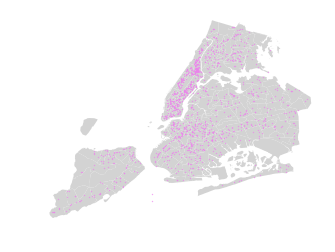

In [17]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_religion.plot(ax=ax, markersize=0.1, color='violet')
print('représentation des lieux de culte sur la carte:')
print(type(df_religion))

On remarque qu'il y a un très grand nombre de lieux de culte dans la ville, et que bien que principalement situés sur la presqu'ile de Manhattan, ils sont répandus sur la totalité de la ville.

In [18]:
#consulate
df_consulate=df_PoI[df_PoI.dum_consulate!=0]
df_consulate.reset_index(drop=True, inplace=True)

représentation des consulats sur la carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


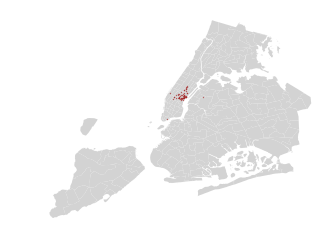

In [19]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_consulate.plot(ax=ax, markersize=0.1, color='brown')
print('représentation des consulats sur la carte:')
print(type(df_consulate))

Les consulats sont quant à eux principalement dans l'upper east side, quartier le plus huppé de Manhattan. Ils peuvent donc être des indicateurs concernant la proximité d'une population extrêmement aisée, et donc moins regardante sur le montant des pourboires qu'elle laisse.

In [21]:
#park
df_park=df_PoI[df_PoI.dum_park!=0]
df_park.reset_index(drop=True, inplace=True)

représentation des parcs sur la carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


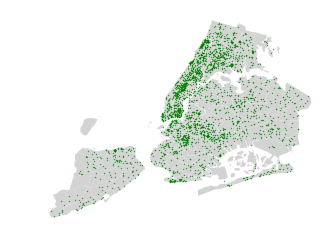

In [22]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_park.plot(ax=ax, markersize=0.1, color='green')
print('représentation des parcs sur la carte:')
print(type(df_park))

Comme les lieux de culte, les points verts sont extrêmenet présent dans la ville et répartie sur la totalité de la ville.

In [23]:
#theatre
df_theatre=df_PoI[df_PoI.dum_theatre!=0]
df_theatre.reset_index(drop=True, inplace=True)

Représentation des théâtres sur une carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


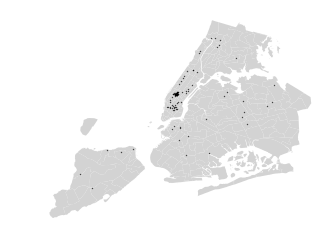

In [24]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_theatre.plot(ax=ax, markersize=0.1, color='black')
print('Représentation des théâtres sur une carte:')
print(type(df_theatre))

Les théâtres sont très concentrés sur Manhattan et en particulier sur la zone de Times Square. Ils peuvent un indicateur à la fois de la présence de touriste ou d'une population suffisament aisée pour se permettre ces activités culturelles.

In [25]:
#school
df_school=df_PoI[df_PoI.dum_school!=0]
df_school.reset_index(drop=True, inplace=True)

Représentation des établissements scolaires sur une carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


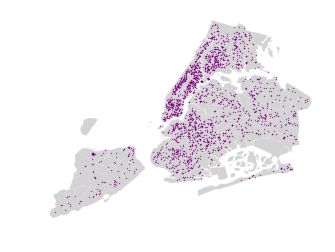

In [26]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_school.plot(ax=ax, markersize=0.1, color='purple')
print('Représentation des établissements scolaires sur une carte:')
print(type(df_school))

Les établissements scolaires sont bien répartis sur la totalité de la ville.

In [27]:
#library
df_library=df_PoI[df_PoI.dum_library!=0]
df_library.reset_index(drop=True, inplace=True)

Représentation des bibliothèques sur une carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


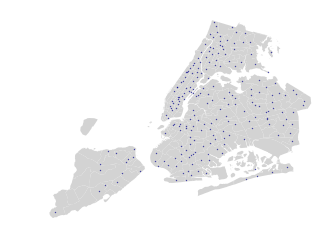

In [28]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_library.plot(ax=ax, markersize=0.1, color='darkblue')
print('Représentation des bibliothèques sur une carte:')
print(type(df_library))

In [29]:
#daycare
df_daycare=df_PoI[df_PoI.dum_daycare!=0]
df_daycare.reset_index(drop=True, inplace=True)

Représentation des crêches sur une carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


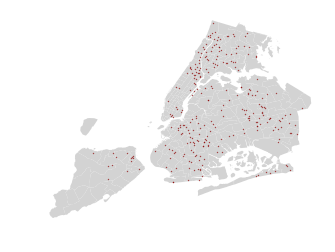

In [30]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_daycare.plot(ax=ax, markersize=0.1, color='darkred')
print('Représentation des crêches sur une carte:')
print(type(df_daycare))

Les crêches, contrairement aux autres batiments, sont principalement situés hors de Manhattan. Les crêches étant payantes aux Etats-Unis, elles sont l'indicateur d'une population familiale, active et relativement aisée.

In [31]:
#cemetery
df_cemetery=df_PoI[df_PoI.dum_cemetery!=0]
df_cemetery.reset_index(drop=True, inplace=True)

Représentation des cimetières sur une carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


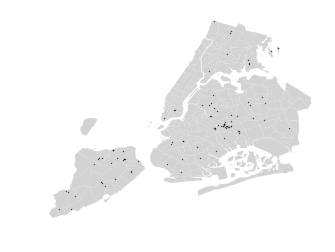

In [32]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_cemetery.plot(ax=ax, markersize=0.1, color='black')
print('Représentation des cimetières sur une carte:')
print(type(df_cemetery))

Les cimetières sont presque tous hors de Manhattan, ils sont souvent situés dans des zones où le foncier est moins chers et donc où les pourboires peuvent être moins importants.

## b) Préparation de la base de données des courses de taxi de juin 2016

On charge la donnée concernant les courses de taxi. Dans la mesure où l'on se concentre sur l'importance des caractéristiques géographiques sur le pourboire, nous enlevons les courses ne rentrant pas dans ce périmètre c'est-à-dire les courses ayant un lieu de prise en charge ou de dépôt hors de la ville de New York.
En outre, notre analyse se restreint aux courses payées en carte bancaire, car pour les courses en cash le pourboire n'est pas enregistré.

In [33]:
#Chargement de la donnée
data = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/yellow_tripdata_2016-06.csv'
df = pd.read_csv(data, sep=',')
df.head()

#on ne garde que les courses payées en carte bleue pour avoir celles où le pourboire apparait
df = df[df.payment_type==1]

#on ne garde que les courses avec prise en charge et dépôt dans la ville
df = df[(df['pickup_longitude'] < -73.7) & (df['pickup_longitude'] > -74.1) & (df['pickup_latitude'] > 40.4) & (df['pickup_latitude'] < 51)]

#réinitialisation de l'index après le nettoyage
df.reset_index(drop=True, inplace=True)


Le nombre de données étant trop important pour nos machines, nous choisissons de travailler sur un échantillon.
Sur cet échantillon, nous avons converti les données gégraphiques (latitude et longitude) en point géometrique. Autour de ce point nous avons tracé un cercle.

On crée une périmetre autour de chaque point de prise en charge:


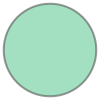

In [34]:
random.seed(35)
# assez lent, !!! on crée df0 = les 100 premières obs de la grosse base
df0 = df.sample(100000).reset_index()
#on crée un identifiant unique par course
df0['Id_course']= df0.index
df0.head()
df0['pts'] = gpd.GeoSeries([Point(xy) for xy in zip(df0.pickup_longitude, df0.pickup_latitude)])
df0['circles'] = gpd.GeoSeries(df0.pts).buffer(0.005)
df0=gpd.GeoDataFrame(df0).set_geometry('circles', crs = crs)
print('On crée une périmetre autour de chaque point de prise en charge:')
df0.loc[5, 'circles']

# le problème c'est qu'on a quelques valeurs très éloignées de la zone, il faut absolument les supprimer
# si on ne les supprime pas (essayer avec les 100 premières obs), le plot (les boroughs de NYC) et le subplot
# (les cercles qu'on a dessiné) ne sont plus tout à la même échelle
# = > on sélectionne les observations dont les pickup coordinates ne sortent pas de la zone de NYC


In [35]:
#on utilise une varaible indicatrice sur extra plutot que le chiffre
dummies = pd.get_dummies(df0['extra']!=0)
dummies.head()
df0['dum_extra']=dummies[True]
df0.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Id_course,pts,circles,dum_extra
0,5228492,1,2016-06-24 08:18:25,2016-06-24 08:26:13,1,1.10,-73.934708,40.801453,1,N,...,0.0,0.5,2.00,0.0,0.3,9.80,0,POINT (-73.93470764160156 40.80145263671875),POLYGON ((-73.92970764160157 40.80145263671875...,0
1,694632,1,2016-06-03 11:03:02,2016-06-03 11:36:02,1,2.30,-74.006866,40.728806,1,N,...,0.0,0.5,4.05,0.0,0.3,24.35,1,POINT (-74.00686645507811 40.72880554199219),POLYGON ((-74.00186645507812 40.72880554199219...,0
2,4569347,1,2016-06-19 17:42:51,2016-06-19 17:58:25,1,3.00,-73.994759,40.740028,1,N,...,0.0,0.5,2.00,0.0,0.3,16.30,2,POINT (-73.99475860595702 40.74002838134766),POLYGON ((-73.98975860595702 40.74002838134766...,0
3,950138,2,2016-06-04 09:33:43,2016-06-04 09:38:14,1,0.65,-73.967400,40.788052,1,N,...,0.0,0.5,1.16,0.0,0.3,6.96,3,POINT (-73.96739959716798 40.78805160522461),POLYGON ((-73.96239959716799 40.78805160522461...,0
4,1902367,1,2016-06-06 14:29:50,2016-06-06 14:53:13,1,3.00,-73.947273,40.783360,1,N,...,0.0,0.5,1.00,0.0,0.3,17.80,4,POINT (-73.94727325439453 40.78335952758789),POLYGON ((-73.94227325439454 40.78335952758789...,0


Ensemble des cercles tracés autour des points de prise en charge représenté sur la carte:
<class 'geopandas.geodataframe.GeoDataFrame'>


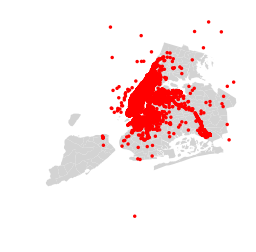

In [36]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df0.plot(ax=ax, markersize=0.01, color='red')
print('Ensemble des cercles tracés autour des points de prise en charge représenté sur la carte:')
print(type(df0))

In [37]:
print('Caractéristique des pourboires:')
df0.tip_amount.describe()

Caractéristique des pourboires:


count    100000.000000
mean          2.802731
std           2.800183
min           0.000000
25%           1.360000
50%           2.000000
75%           3.160000
max         146.300000
Name: tip_amount, dtype: float64

On remarque que les pourboires sont très centrés autour de 2 euros avec peu de variances et des valeurs extrêmes.

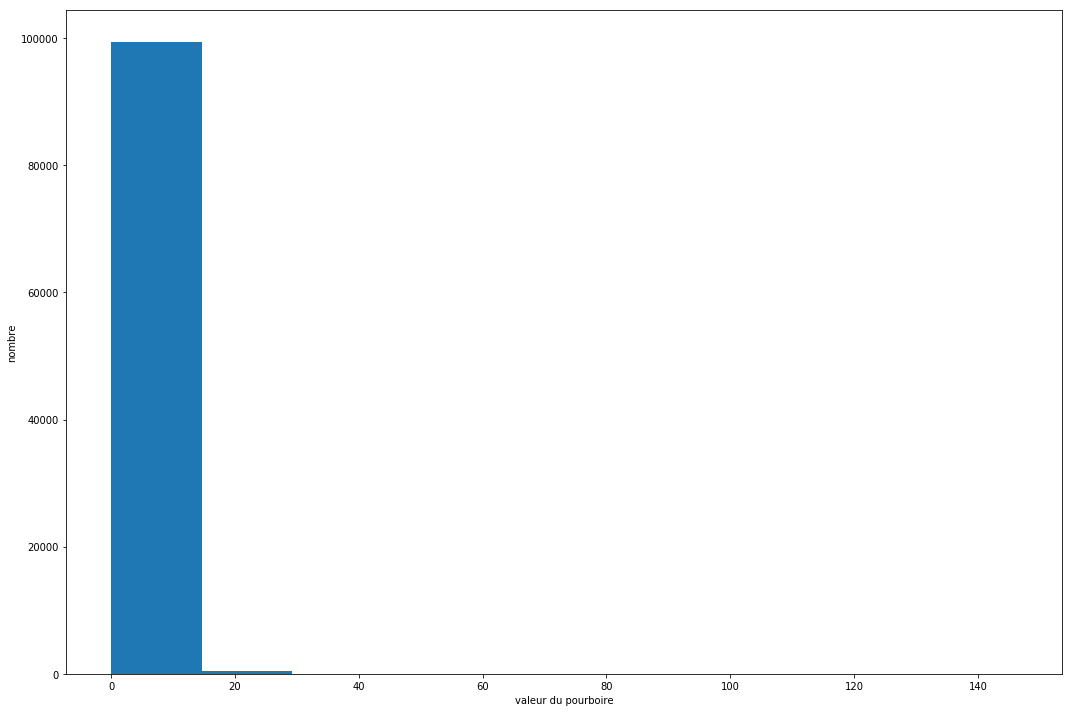

In [38]:
plt.figure(figsize=(15, 10))
plt.hist(df0.tip_amount)
plt.xlabel('valeur du pourboire')
plt.ylabel('nombre')
plt.tight_layout()

Nous avons ensuite compté le nombre d'occurence pour chaque catégorie dans le périmetre que nous avons tracé autour de chaque point de prise en charge.

In [39]:
# college
nb_coll_circle = gpd.sjoin(df_college, df0.copy(),op='within')
count_coll = nb_coll_circle.groupby('Id_course').size()
count_coll.name="nb_college"

#subway entrances
nb_sub_circle = gpd.sjoin(df_subway, df0.copy(),op='within')
count_sub = nb_sub_circle.groupby('Id_course').size()
count_sub.name="nb_subway"


#hospitals
nb_hosp_circle = gpd.sjoin(geodf_hospital, df0.copy(),op='within')
count_hosp = nb_hosp_circle.groupby('Id_course').size()
count_hosp.name="nb_hospital"


#religion
nb_rel_circle = gpd.sjoin(df_religion, df0.copy(),op='within')
count_rel = nb_rel_circle.groupby('Id_course').size()
count_rel.name="nb_religion"

#consulate
nb_cons_circle = gpd.sjoin(df_consulate, df0.copy(),op='within')
count_cons = nb_cons_circle.groupby('Id_course').size()
count_cons.name="nb_consulate"

#park
nb_park_circle = gpd.sjoin(df_park, df0.copy(),op='within')
count_park = nb_park_circle.groupby('Id_course').size()
count_park.name="nb_park"

#theatre
nb_th_circle = gpd.sjoin(df_theatre, df0.copy(),op='within')
count_th = nb_th_circle.groupby('Id_course').size()
count_th.name="nb_theatre"

#school
nb_sc_circle = gpd.sjoin(df_school, df0.copy(),op='within')
count_sc = nb_sc_circle.groupby('Id_course').size()
count_sc.name="nb_school"

#library
nb_lib_circle = gpd.sjoin(df_library, df0.copy(),op='within')
count_lib = nb_lib_circle.groupby('Id_course').size()
count_lib.name="nb_library"

#daycare
nb_dc_circle = gpd.sjoin(df_daycare, df0.copy(),op='within')
count_dc = nb_dc_circle.groupby('Id_course').size()
count_dc.name="nb_daycare"

#cemetery
nb_cem_circle = gpd.sjoin(df_cemetery, df0.copy(),op='within')
count_cem = nb_cem_circle.groupby('Id_course').size()
count_cem.name="nb_cemetery"


df0_count = pd.concat([df0, count_coll,count_sub,count_hosp,count_rel,count_cons,count_park,count_th,count_sc,count_lib ,count_dc,count_cem], axis=1)
df0_count[['nb_college','nb_subway','nb_hospital','nb_religion','nb_consulate','nb_park','nb_theatre','nb_school','nb_library','nb_daycare','nb_cemetery']]=df0_count[['nb_college','nb_subway','nb_hospital','nb_religion','nb_consulate','nb_park','nb_theatre','nb_school','nb_library','nb_daycare','nb_cemetery']].fillna(0)

df0_count.head()
df0_count.columns


Index(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'Id_course', 'pts', 'circles',
       'dum_extra', 'nb_college', 'nb_subway', 'nb_hospital', 'nb_religion',
       'nb_consulate', 'nb_park', 'nb_theatre', 'nb_school', 'nb_library',
       'nb_daycare', 'nb_cemetery'],
      dtype='object')

Nous avons ensuite divisé nos données en train et en test. Pour le train nous n'avons gardé que les données concernant le nombre de passager, la distance parcourue, le prix de la course, la présence d'un extra ( lié à une conduite en horaire nocturne ou en heure de pointe) couplées aux données géographiques extraites précédemment.

In [40]:
# on divise en train et en test
f=df0_count.columns.get_loc("passenger_count")
i=df0_count.columns.get_loc("payment_type")
j=df0_count.columns.get_loc("fare_amount")
k=df0_count.columns.get_loc("dum_extra")

l=list(range(f,f+2))+list(range (i+1,j+1))+list(range(k,df0_count.shape[1]))

X, y = df0_count[df0_count.columns[l]], df0_count['tip_amount']



In [41]:
#on ajoute une constante pour pouvoir ensuite faire une régression avec la méthode des OLS avec une constante
X = sm.add_constant(X)
X.head()

,const,passenger_count,trip_distance,fare_amount,dum_extra,nb_college,nb_subway,nb_hospital,nb_religion,nb_consulate,nb_park,nb_theatre,nb_school,nb_library,nb_daycare,nb_cemetery
0,1.0,1,1.10,7.0,0,0.0,5.0,1.0,5.0,0.0,14.0,0.0,9.0,1.0,2.0,0.0
1,1.0,1,2.30,19.5,0,0.0,11.0,0.0,2.0,0.0,7.0,2.0,10.0,0.0,0.0,0.0
2,1.0,1,3.00,13.5,0,3.0,31.0,0.0,6.0,0.0,0.0,1.0,17.0,2.0,0.0,0.0
3,1.0,1,0.65,5.0,0,0.0,6.0,0.0,2.0,0.0,12.0,0.0,13.0,1.0,0.0,0.0
4,1.0,1,3.00,16.0,0,0.0,8.0,2.0,1.0,0.0,7.0,0.0,9.0,0.0,2.0,0.0


In [55]:
# on sépare les données explicatives et expliquées en train et en test pour vérifier la valeur de nos prédictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=42)

X.columns

Index(['const', 'passenger_count', 'trip_distance', 'fare_amount', 'dum_extra',
       'nb_college', 'nb_subway', 'nb_hospital', 'nb_religion', 'nb_consulate',
       'nb_park', 'nb_theatre', 'nb_school', 'nb_library', 'nb_daycare',
       'nb_cemetery'],
      dtype='object')

In [56]:
#on crée un tableau de variables explicatives sans la colonne constante pour ensuite pouvoir faire des régressions 
# sans cette constante
X1_train=X_train.drop('const',1)
X1_test=X_test.drop('const',1)
X1=X.drop('const',1)
X1.head()

,passenger_count,trip_distance,fare_amount,dum_extra,nb_college,nb_subway,nb_hospital,nb_religion,nb_consulate,nb_park,nb_theatre,nb_school,nb_library,nb_daycare,nb_cemetery
0,1,1.10,7.0,0,0.0,5.0,1.0,5.0,0.0,14.0,0.0,9.0,1.0,2.0,0.0
1,1,2.30,19.5,0,0.0,11.0,0.0,2.0,0.0,7.0,2.0,10.0,0.0,0.0,0.0
2,1,3.00,13.5,0,3.0,31.0,0.0,6.0,0.0,0.0,1.0,17.0,2.0,0.0,0.0
3,1,0.65,5.0,0,0.0,6.0,0.0,2.0,0.0,12.0,0.0,13.0,1.0,0.0,0.0
4,1,3.00,16.0,0,0.0,8.0,2.0,1.0,0.0,7.0,0.0,9.0,0.0,2.0,0.0


# 2- Régression sur les données géographiques

## a) régression linéaire et analyse de l'intérêt des variables

On représente dans un premier temps les varaiations du montant des pourboires en fonction de chaque variable explicative.

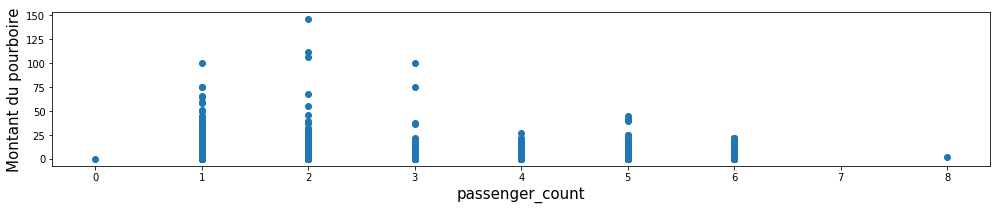

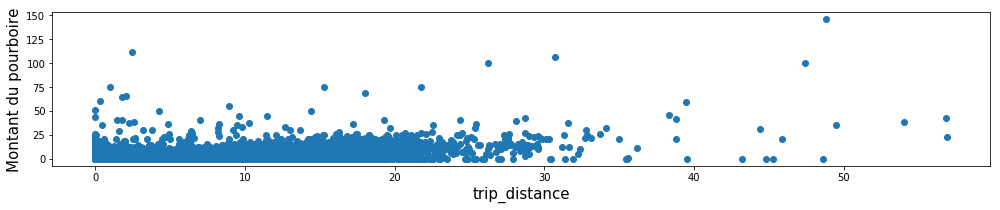

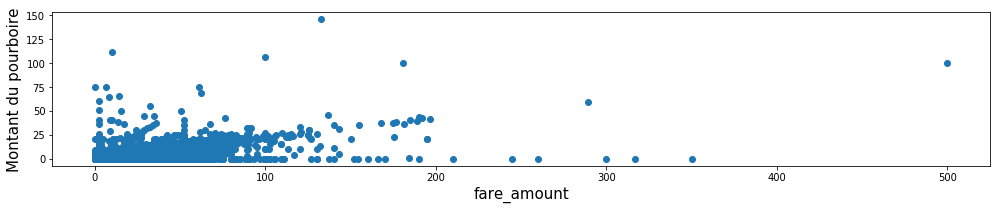

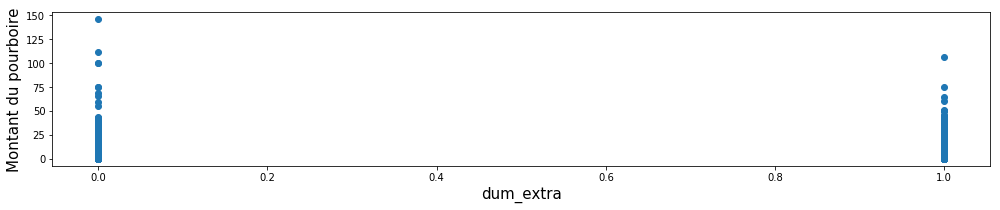

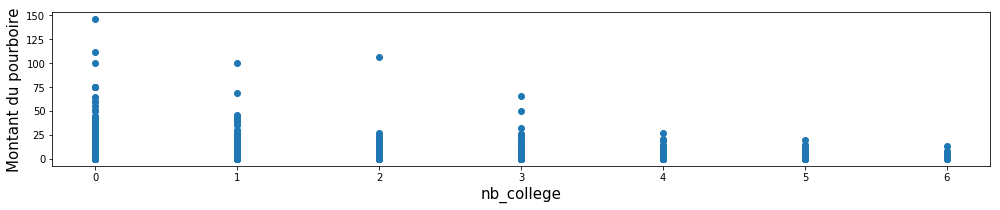

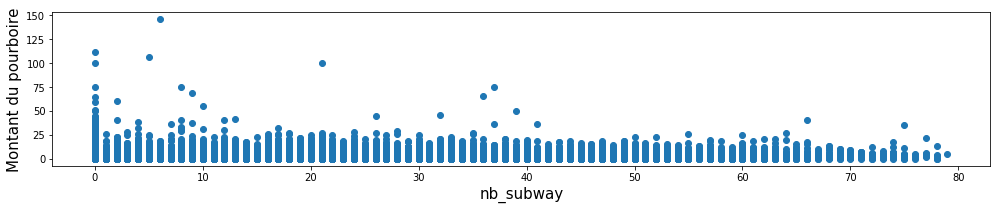

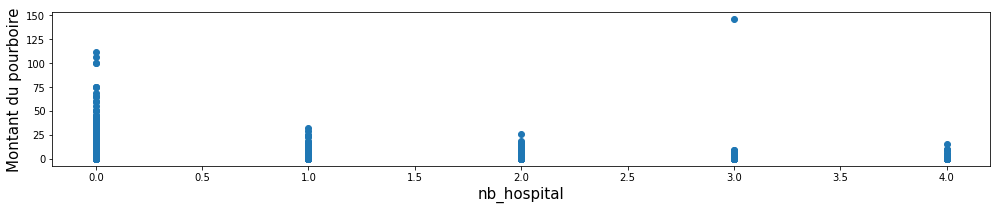

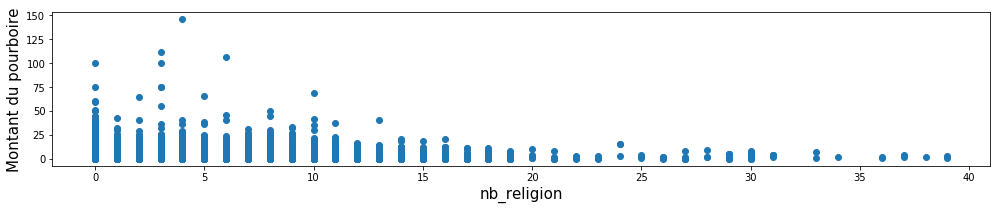

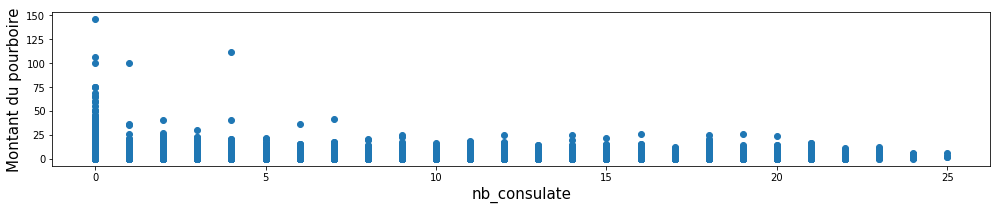

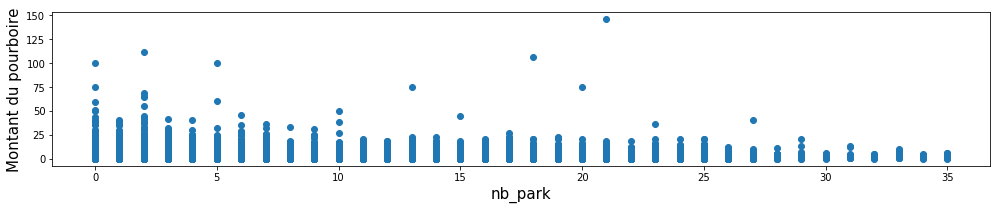

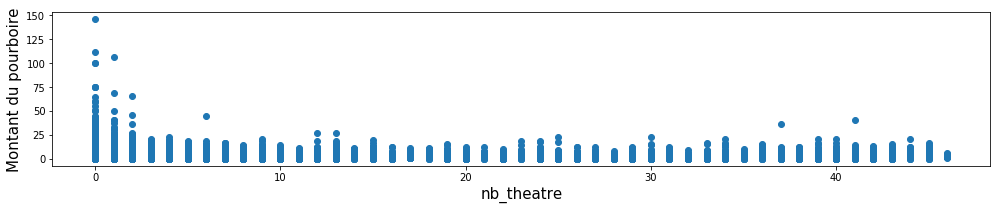

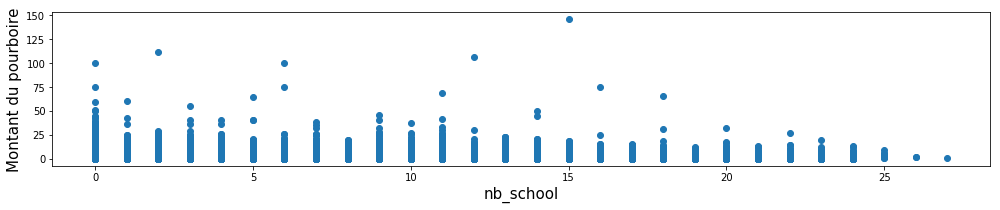

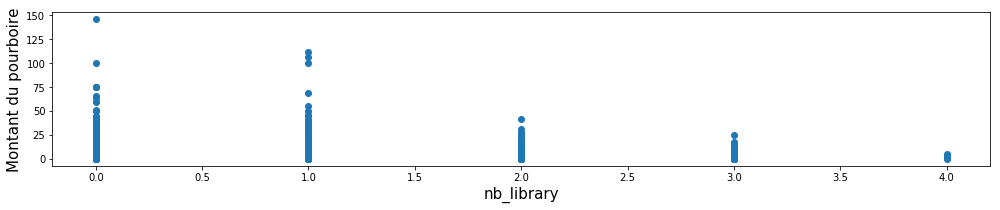

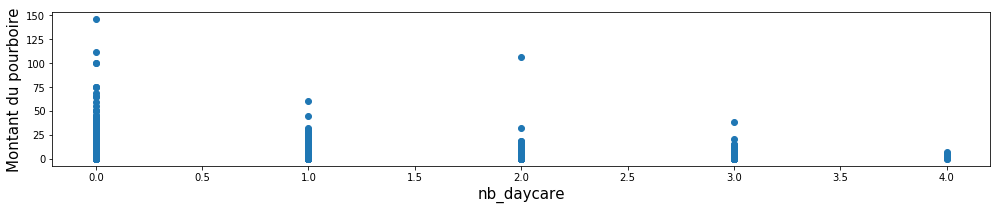

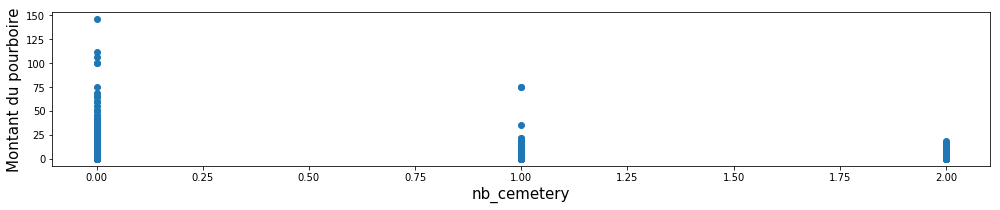

In [57]:
for i in range(X1.shape[1]):
    plt.figure(figsize=(14, 3))
    plt.scatter(X1.iloc[:,i], y)
    plt.ylabel('Montant du pourboire', size=15)
    plt.xlabel(X1.columns[i], size=15)
    plt.tight_layout()

On remarque tout d'abord qu'un grand nombre de course ont des lieux de prise en charge en ayant aucun des batiments notables à proximté. On remarque également qu'aucune variable ne semble expliquer de manière claire les varaiations dans les pourboires.

On va ensuite utiliser une régression linéaire de type OLS pour obtenir les p-value associées à chaque variables et pouvoir élminer les variables qui ne passent pas le test.

In [59]:
lm1 = sm.OLS(y,X).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     9273.
Date:                Sat, 06 Jan 2018   Prob (F-statistic):               0.00
Time:                        23:12:59   Log-Likelihood:            -2.0127e+05
No. Observations:              100000   AIC:                         4.026e+05
Df Residuals:                   99984   BIC:                         4.027e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5423      0.022     24.776      0.000       0.499       0.585
passenger_count  3.052e-05      0.004      0.007      0.994      -0.009       0.009
trip_distance       0.2034      0.004     54.703      0.000       0.196       0.211
fare_amount         0.1197      0.001    100.521      0.000       0.117       0.122
dum_extra           0.0375      0.012      3.234      0.001       0.015       0.060
nb_college          0.0108      0.006      1.758      0.079      -0.001       0.023
nb_subway           0.0004      0.000      0.774      0.439      -0.001       0.001
nb_hospital        -0.0368      0.016     -2.301      0.021      -0.068      -0.005
nb_religion        -0.0033      0.002     -1.723      0.085      -0.007       0.000
nb_consulate        0.0050      0.002      3.070      0.002       0.002       0.008
nb_park            -0.0016      0.001     -1.298      0.194      -0.004       0.001
nb_theatre          0.0009      0.001      0.805      0.421      -0.001       0.003
nb_school          -0.0061      0.001     -4.325      0.000      -0.009      -0.003
nb_library         -0.0164      0.009     -1.811      0.070      -0.034       0.001
nb_daycare         -0.0128      0.012     -1.056      0.291      -0.037       0.011
nb_cemetery        -0.0437      0.019     -2.348      0.019      -0.080      -0.007
==============================================================================
Omnibus:                   170100.487   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1461340360.114
Skew:                          10.855   Prob(JB):                         0.00
Kurtosis:                     594.820   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On remarque ici que la distance parcourue, le montant de la course final, la présence d'une surcharge (pour conduite de nuit ou en période de pointe), le nombre d'hopitaux, de consulat, le nombre d'établissements scolaires et de cimetières ont un p-value inférieure à 5%. Pour cette raison nous pouvons les estimer suffisamment significatives pour les garder comme variables explicatives. 

Tandis que nous supprimons les variables explicatives ayant une p-value au dessus de 5%, car d'après cette régression linéaire avec les OLS, nous ne parvenons pas à rejeter l'hypothèse selon laquelle leurs coefficients respectifs sont nuls dans la régression.

On remarque que les varaibles explicatives estimées significatives sont celles qui sont les mieux réparties sur la totalité de la ville et donc plus facilement incluses dans les différentes courses et en plus grand nombre, sans être pour autant à tous les coins de rues comme les parcs ou lieux de culte, ou au contraire, sont partcilièrement assimilé à un quartier comme les consulats concentrés dans l'upper east side. 

On va donc créer une nouvelle base de données comprenant uniquement les variables explicatives retenues.

In [62]:
X2_train=X1_train[['trip_distance','dum_extra','fare_amount','nb_hospital','nb_consulate','nb_cemetery','nb_school']]
X2_test=X1_test[['trip_distance','dum_extra','fare_amount','nb_hospital','nb_consulate','nb_cemetery','nb_school']]
X2=X1[['trip_distance','dum_extra','fare_amount','nb_hospital','nb_consulate','nb_cemetery','nb_school']]
X2.head()

,trip_distance,dum_extra,fare_amount,nb_hospital,nb_consulate,nb_cemetery,nb_school
0,1.10,0,7.0,1.0,0.0,0.0,9.0
1,2.30,0,19.5,0.0,0.0,0.0,10.0
2,3.00,0,13.5,0.0,0.0,0.0,17.0
3,0.65,0,5.0,0.0,0.0,0.0,13.0
4,3.00,0,16.0,2.0,0.0,0.0,9.0


## b) Tentative de prédiction à l'aide de modèle de régression
### 1- Régression linéaire


In [66]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X2_train, y_train)

# Make predictions using the testing set
y2_pred = regr.predict(X2_test)

# The coefficients
res_LIN=pd.DataFrame()
res_LIN['variables']=X2.columns
res_LIN['Coefficients']=regr.coef_
print(res_LIN)

#intercept
print("Intercept: %.2f"
      % regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y2_pred))


# Explained variance score: 1 is perfect prediction
print('R2: %.2f' % regr.score(X2_train, y_train))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y2_pred))


       variables  Coefficients
0  trip_distance      0.182842
1      dum_extra      0.026542
2    fare_amount      0.123844
3    nb_hospital     -0.043211
4   nb_consulate      0.004546
5    nb_cemetery     -0.049621
6      nb_school     -0.008293
Intercept: 0.53
Mean squared error: 3.56
R2: 0.60
Variance score: 0.57


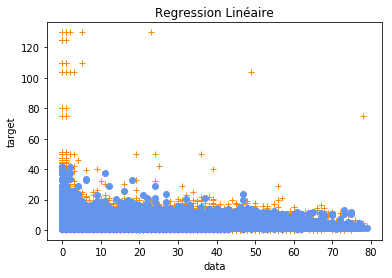

In [179]:
plt.plot(X2_test, y_test,'+', color='darkorange', label='Réel')
plt.plot(X2_test, y_pred,'o', color='cornflowerblue', label='Predit')
plt.xlabel('Variables explicatives')
plt.ylabel('Montant du pourboire')
plt.title('Regression Linéaire')
plt.show()

On remarque qu'avec la régression linéaire, que si la présence de consulats à proximité du lieu de prise en charge favorise positivement le montant du pourboire, celle d'une école, mais plus encore d'un cimetière ou d'un hopital a une influence négative sur le pourboire.
Comme on pouvait s'y attendre, plus la distance parcourue est importante ou plus le prix de la course est grand (les deux variables sont non corrélées grâce aux heures de pointe où les taxis parcourent une faible distance à grand prix), plus le pourboire sera important.
Le risque quadratique obtenu est cependant trsè élevé, surtout pour des varaibles principalement conprises entre 1 et 4. 

### 2-Support Vector Regression

In [67]:
#Support Vector Regression
from sklearn.svm import SVR
clf = SVR()
clf.fit(X2_train, y_train)
print("SVR")
ySVR_pred=clf.predict(X2_test)

SVR


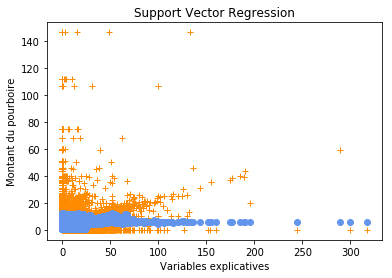

In [68]:
plt.plot(X2_test, y_test,'+', color='darkorange', label='data')
plt.plot(X2_test, ySVR_pred,'o', color='cornflowerblue', label='Prediction')
plt.xlabel('Variables explicatives')
plt.ylabel('Montant du pourboire')
plt.title('Support Vector Regression')
plt.show()

In [69]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, ySVR_pred))

Mean squared error: 4.03


Comme pour la régression linéaire on retrouve encore un risque quadratique très haut. Les valeurs prédites moins dispersées, formant presque une droite constante autour de 3. ON peut donc estimer que cette prédiction est non concluante.

### 3 - Gradient Boosting Regressor

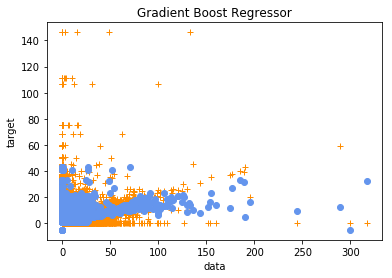

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor()
clf.fit(X2_train, y_train)

yGBR_pred = clf.predict(X2_test)

plt.plot(X2_test, y_test,'+', color='darkorange', label='data')
plt.plot(X2_test, yGBR_pred,'o', color='cornflowerblue', label='Prediction')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Gradient Boost Regressor')
plt.show()

In [71]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, yGBR_pred))

Mean squared error: 3.55


In [72]:
#Importance des principales varaibles dans la prédiction
res_GBR=pd.DataFrame()
res_GBR['variables']=X2.columns
res_GBR['importance']=clf.feature_importances_
print(res_GBR)

       variables  importance
0  trip_distance    0.380188
1      dum_extra    0.015588
2    fare_amount    0.520895
3    nb_hospital    0.007976
4   nb_consulate    0.019322
5    nb_cemetery    0.000000
6      nb_school    0.056030


On retrouve ici aussi un risque quadratique trop important de 3.55. 

Encore une fois, la distance parcourue et le montant de la course sont les deux variables explicatives les plus importantes d'après ce modèle. Contrairement à la regression linéaire, on remarque qu'ici le nombre de cimetière est considéré comme ayant une importance nulle dans la prévision du montant du pourboire. Dans ce modèle, le nombre d'établissement scolaires (primaires et secondaires)est nettement plus important que dans la régression linéaire.
On obtient des valeurs prédites moins centrées qu'avec le support vector regressor, mais le modèle, du fait de son trop grand risque quadratique reste non concluant. 


### 4- Decision Tree Regressor


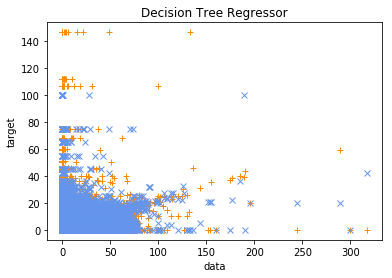

In [73]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf.fit(X2_train, y_train)

yDTR_pred = clf.predict(X2_test)

plt.plot(X1_test, y_test,'+', color='darkorange', label='data')
plt.plot(X1_test, yDTR_pred,'x', color='cornflowerblue', label='Prediction')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Decision Tree Regressor')
plt.show()

In [74]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, yDTR_pred))

Mean squared error: 6.30


In [75]:
# Explained variance score: 1 is perfect prediction
res_DTR=pd.DataFrame()
res_DTR['variables']=X2.columns
res_DTR['importance']=clf.feature_importances_
print(res_DTR)

       variables  importance
0  trip_distance    0.191864
1      dum_extra    0.014481
2    fare_amount    0.682032
3    nb_hospital    0.006515
4   nb_consulate    0.028048
5    nb_cemetery    0.006967
6      nb_school    0.070093


Dans le cadre de l'arbre de décision le risque quadratique est vraiment très important. 
Le montant de la course semble être le facteur premier dans la prévision du pourboire, suivi de la distance parcourue puis de très loin par la présence de consulat.
Encore une fois ce modèle est non-concluant dans la prédiction du montant du pourboire.

## c) Conclusion

On remarque que peu importe le modèle de régression utilisé, le score obtenu est vraiment trop important. De plus, si la distance parcourue et le montant de la course domine incontestablement la prédiction, les résultats concernant l'importance des autres variables dans la prédiction varie entre les modèles. Nous sommes donc incapable de déterminer quels sont les types de batiments qu'il faut avoir en priorité à proximité du lieu de prise en charge pour esperer un gros pourboire.

Cette incapacité à prédire le montant du pourboire est certainement liée à la trop grande concentration des pourboires sur un faible intervalle de valeurs et aux trop faibles variations entre les variables explicatives. En effet la précision d'une prédiction est positivement liée à cette dernière: plus il y a de varaition entre les données disponibles d'une variables explicatives plus on peut mesurer de manière précise son influence sur la variable expliquée. Or, on voit dans le tableau ci-dessous que pour la grande majorité des varaibles, les trois premiers quantiles sont tous très serrés autour de la moyenne.

Nous avons pensé à agrandir les cercles pour capter un plus grand nombre d'éléments. Cependant les courses étant principalement concentrées dans la région de Manhattan, les cercles se seraient encore un peu plus chevauchés et nous n'aurions pas obtenu une plus grande dispersion dans les variables explicatives: les valeurs auraient toutes augmentées de manière comparable pour la grande majorité des observations.

In [76]:
df0_count[['passenger_count', 'trip_distance', 'fare_amount', 'dum_extra',
       'nb_college', 'nb_subway', 'nb_hospital', 'nb_religion', 'nb_consulate',
       'nb_park', 'nb_theatre', 'nb_school', 'nb_library', 'nb_daycare',
       'nb_cemetery']].describe()

,passenger_count,trip_distance,fare_amount,dum_extra,nb_college,nb_subway,nb_hospital,nb_religion,nb_consulate,nb_park,nb_theatre,nb_school,nb_library,nb_daycare,nb_cemetery
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.640530,3.198881,13.861342,0.506110,0.769400,17.209410,0.088920,5.656290,2.006680,7.151900,2.493650,7.341740,0.684600,0.214570,0.067110
std,1.297971,3.783706,11.697566,0.499965,1.095899,14.640165,0.368476,3.689511,4.086992,5.580179,6.463742,5.154053,0.762856,0.506984,0.314273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.100000,7.000000,0.000000,0.000000,5.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,1.000000,1.850000,10.000000,1.000000,0.000000,15.000000,0.000000,5.000000,0.000000,5.000000,1.000000,7.000000,1.000000,0.000000,0.000000
75%,2.000000,3.452500,16.000000,1.000000,1.000000,26.000000,0.000000,8.000000,2.000000,10.000000,2.000000,11.000000,1.000000,0.000000,0.000000
max,8.000000,56.920000,500.000000,1.000000,6.000000,79.000000,4.000000,39.000000,25.000000,35.000000,46.000000,27.000000,4.000000,4.000000,2.000000


## CONCLUSION SUR LES DONNEES GEOGRAPHIQUES

Nous ne sommes pas parvenues à prédire de manière suffisamment précise les montants des pourboires en fonction des données géographiques que nous avons recueillies. Les données disponibles et accessibles ne nous donnaient trop peu d'information sur les caractéristqiues socio-économiques des clients et des zones de prise en charge.

Face à ce constat, nous avons décidé d'adopter une toute autre perspective en nous concentrant sur l'apect temporel. 